Summary:
* Encoding (no rff & Binary hypervectors)
* Modeling (Binary hypervectors)

===============================
* Encoding (rff & vsa)
* Modeling vsa (Cosine & Manhattan)

### Encoding (No RFF)


In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
dim = 10000   # Dimension of each hypervector
num = 256     # Number of unique hypervectors (e.g., for each pixel intensity)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available



# Existing functions (from the github)
def get_hdv(dim=10000, num=1):
    assert num > 0, "[Error] Only support nonzero size in get_hdv()"
    if num == 1:
        return np.random.choice([-1, 1], size=dim)
    else:
        result = np.random.randint(2, size=(num, dim))
        result = (result - 0.5) * 2
        return result.astype('int')

def build_item_mem(dim, num):
    assert num > 1, "No need of this function if only one vector in the item memory."
    item_mem = get_hdv(dim=dim, num=num)
    index = np.arange(dim // 2)
    np.random.shuffle(index)
    interval = int((dim / 2) / (num - 1))
    pointer = 0
    for i in range(1, num):
        new_item = np.copy(item_mem[i - 1])
        if i == num - 1:
            new_item[index[pointer:]] *= -1
        else:
            new_item[index[pointer: pointer + interval]] *= -1
        pointer += interval
        item_mem[i] = new_item
    item_mem = torch.from_numpy(item_mem)
    return item_mem

def encode_one_img(x, item_mem):
    rv = item_mem[x[0]]
    for i in range(1, x.shape[0]):
        rv = torch.roll(rv, i)
        rv = -rv * item_mem[x[i]]
    return rv

def encode_data_extract_labels(datast, dim, item_mem):
    n = len(datast)
    rv = torch.zeros((n, dim))
    labels = torch.zeros(n).long()

    # Wrap the loop with tqdm for a progress bar
    for i in tqdm(range(n), desc="Encoding dataset"):
        rv[i] = encode_one_img((255 * datast[i][0].view(-1)).int(), item_mem)
        labels[i] = datast[i][1]

    return rv, labels


#### Encoding test

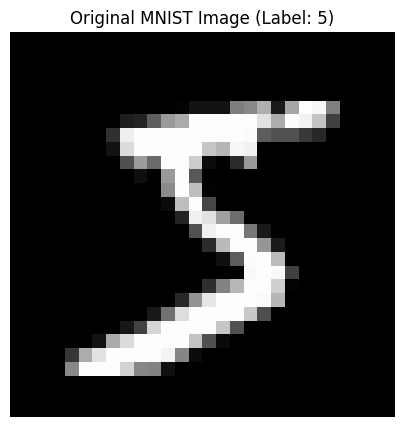

tensor([-1, -1,  1,  ..., -1,  1, -1])


In [ ]:
'''import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Parameters
dim = 10000  # Dimension of each hypervector
num = 256    # Number of unique hypervectors (e.g., for each pixel intensity)

# Load a single image from MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
img, label = mnist_dataset[0]  # First image and label

# Plot the original MNIST image
plt.figure(figsize=(5, 5))
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Original MNIST Image (Label: {label})")
plt.axis('off')
plt.show()

# Encode the image as a test (optional, if you want to verify the encoding process)
item_mem = build_item_mem(dim, num)
encoded_hv = encode_one_img((255 * img.view(-1)).int(), item_mem)
print(encoded_hv)


### Modeling (Binary Hypervectors)

In [ ]:
from torch.utils.data import Subset
import random

def create_class_centroids(train_hypervectors, train_labels, num_classes, dim):
    class_centroids = torch.zeros((num_classes, dim))
    for c in range(num_classes):
        # Select all hypervectors for class c
        class_hvs = train_hypervectors[train_labels == c]
        print("shape class_hvs",class_hvs.shape )
        # Bundle by summing and binarizing (sign function)
        class_centroid = class_hvs.sum(dim=0)
        print("shape class_centroid",class_centroid.shape )
        class_centroids[c] = torch.sign(class_centroid)  # Binarize to {-1, 1}

    return class_centroids

# 2. Inference: Classify a Test Hypervector
def classify(test_hv, class_centroids):
    similarities = [torch.dot(test_hv, class_centroid) for class_centroid in class_centroids]
    predicted_class = torch.argmax(torch.tensor(similarities)).item()
    return predicted_class

# 3. Full Inference for a Test Set
def test_model(test_hypervectors, test_labels, class_centroids):
    predictions = []
    for test_hv in test_hypervectors:
        pred_class = classify(test_hv, class_centroids)
        predictions.append(pred_class)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Main code for training and testing the HDC model on encoded data
def main():
    # Define transformations: Convert images to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Load the full MNIST dataset
    full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Create a subset of the MNIST dataset
    train_indices = random.sample(range(len(full_train_dataset)), small_train_size)
    test_indices = random.sample(range(len(full_test_dataset)), small_test_size)
    train_dataset = Subset(full_train_dataset, train_indices)
    test_dataset = Subset(full_test_dataset, test_indices)

    # Build item memory
    item_mem = build_item_mem(dim=dim, num=num)

    # Encode training and test data
    train_hypervectors, train_labels = encode_data_extract_labels(train_dataset, dim, item_mem)
    test_hypervectors, test_labels = encode_data_extract_labels(test_dataset, dim, item_mem)

    # Create class centroids (learning step)
    num_classes = 10  # Digits 0-9 in MNIST
    class_centroids = create_class_centroids(train_hypervectors, train_labels, num_classes, dim)

    # Test the model (inference step)
    test_accuracy = test_model(test_hypervectors, test_labels, class_centroids)
    print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

if __name__ == "__main__":
    main()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.44MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Encoding dataset: 100%|██████████| 1000/1000 [00:36<00:00, 27.48it/s]


shape class_hvs torch.Size([506, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([558, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([486, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([518, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([522, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([420, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([489, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([513, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([518, 10000])
shape class_centroid torch.Size([10000])
shape class_hvs torch.Size([470, 10000])
shape class_centroid torch.Size([10000])
Test Accuracy: 11.80%
Final Test Accuracy: 11.80%


### RFF Encoding

In [ ]:
import numpy as np
import torch
import scipy.stats
import time

# Parameters (previously set in __init__)
input_dim = 10000
gamma = 0.3
num = 256
gorder = 2      # we try [2,8,16,32]
output_dim = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to map points in cyclic group representation
def pts_map(x, r=1.0):
    theta = 2.0 * np.pi / (1.0 * gorder) * x
    pts = r * torch.stack([torch.cos(theta), torch.sin(theta)], -1)
    return pts

# Group Random Fourier Features
def group_rff(x, sigma):
    intervals = sigma * torch.tensor(
        [scipy.stats.norm.ppf(i * 1.0 / gorder) for i in range(1, gorder)]
    ).float()
    print('The threshold to discretize Fourier features to group elements:', intervals)

    group_index = torch.zeros_like(x)
    group_index[x <= intervals[0]] = 0
    group_index[x > intervals[-1]] = gorder - 1
    if gorder > 2:
        for i in range(1, gorder - 1):
            group_index[(x > intervals[i - 1]) & (x <= intervals[i])] = i
    return group_index

# Build item memory with random Fourier features
def build_item_mem():
    correction_factor = 1 / 1.4
    x = np.linspace(0, 255, num=256)
    Cov = np.array([
        np.exp(-correction_factor * gamma ** 2 * ((x - y) / 255.0) ** 2 / 2)
        for y in range(256)
    ])
    k = Cov.shape[0]
    assert Cov.shape[1] == k, "Cov is not a square matrix."

    L = np.sin(Cov * np.pi / 2.0)
    eigen_values, eigen_vectors = np.linalg.eigh(L)
    R = eigen_vectors @ np.diag(np.maximum(0, eigen_values) ** 0.5) @ eigen_vectors.T
    item_mem = torch.from_numpy(np.random.randn(output_dim, k) @ R).float()
    item_mem = group_rff(item_mem, np.sqrt((R ** 2).sum(0).max())).T
    return item_mem.to(device)

# Encode a single image
def encode_one_img(x, item_mem):
    x = x.to(device).long()
    bs, channels, num_pixels = x.size()
    rv = item_mem[x.flatten()].view(bs, channels, num_pixels, -1).transpose(0, 2)
    for i in range(num_pixels):
        rv[i] = torch.roll(rv[i], shifts=783 - i, dims=-1)
    rv = torch.sum(rv, dim=0)
    if gorder == 2:
        rv = rv % 2
    return rv.transpose(0, 1).reshape((bs, -1))

# Encode data and extract labels
def encode_data_extract_labels(datast, item_mem):
    channels = datast[0][0].size(0)
    n = len(datast)
    rv = torch.zeros((n, channels * output_dim))
    labels = torch.zeros(n).long()
    print('Start encoding data')
    start_time = time.time()
    batch_size = 128
    data_loader = torch.utils.data.DataLoader(datast, batch_size=batch_size, shuffle=False)

    for i, batch_img in enumerate(data_loader):
        num_imgs = batch_img[0].size(0)
        rv[i * batch_size: i * batch_size + num_imgs] = encode_one_img(
            (255 * batch_img[0].view(num_imgs, channels, -1)).int(), item_mem
        )
        labels[i * batch_size: i * batch_size + num_imgs] = batch_img[1]

        if i % 100 == 99:
            print(f"{(i + 1) * batch_size} images encoded. Total time elapsed: {time.time() - start_time}")

    print('Finish encoding data')
    return rv, labels

# Group bind function
def group_bind(lst):
    results = torch.sum(lst, dim=0)
    return results

# Group bundle function
def group_bundle(lst):
    intervals = torch.tensor([2 * np.pi / gorder * i for i in range(gorder)]) + np.pi / gorder
    pts = torch.sum(pts_map(lst), dim=0)
    raw_angles = 2 * np.pi + torch.arctan(pts[:, 1] / pts[:, 0]) - np.pi * (pts[:, 0] < 0).float()
    angles = torch.fmod(raw_angles, 2 * np.pi)
    return torch.floor(angles / (2.0 * np.pi) * gorder + 1 / 2)

# Similarity function
def cosine_similarity(x, y):
    return torch.sum(torch.sum(pts_map(x) * pts_map(y), dim=-1), dim=-1) * (1.0 / x.size(-1))


### Modeling (Cosine / Manhattan )


In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
from torch.utils.data import Subset
import random
import time

def modular_manhattan_distance(u, v):
    # Compute the element-wise modular distance
    delta = torch.min((u - v) % gorder, (v - u) % gorder)
    distance = 4*(delta.sum())/(input_dim*gorder)
    return 1 - distance

# Create class centroids for each digit (0-9)
def create_class_centroids(train_hypervectors, train_labels, num_classes, dim):
    class_centroids = torch.zeros((num_classes, dim), device=device)
    for c in range(num_classes):
        class_hvs = train_hypervectors[train_labels == c]
        class_centroids[c] = group_bundle(class_hvs)
    return class_centroids

# Classify a single test hypervector
def classify(test_hv, class_centroids):
    # Move test_hv to the same device as class_centroids
    test_hv = test_hv.to(class_centroids.device)

    similarities = [cosine_similarity(test_hv, class_centroid) for class_centroid in class_centroids]
    #similarities = [modular_manhattan_distance(test_hv, class_centroid) for class_centroid in class_centroids]

    predicted_class = torch.argmax(torch.tensor(similarities)).item()
    return predicted_class

# Test the model on a test set
def test_model(test_hypervectors, test_labels, class_centroids):
    test_hypervectors = test_hypervectors.to(class_centroids.device)
    predictions = []
    for test_hv in test_hypervectors:
        pred_class = classify(test_hv, class_centroids)
        predictions.append(pred_class)
    accuracy = accuracy_score(test_labels.cpu(), predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Main function
def main():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # >> for testing smaller datasets:
    # full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    # small_train_size = 50000
    # small_test_size = 10000
    # train_indices = random.sample(range(len(full_train_dataset)), small_train_size)
    # test_indices = random.sample(range(len(full_test_dataset)), small_test_size)
    # train_dataset = Subset(full_train_dataset, train_indices)
    # test_dataset = Subset(full_test_dataset, test_indices)

    # Build item memory with RFF
    item_mem = build_item_mem()

    # Encode training and test data
    train_hypervectors, train_labels = encode_data_extract_labels(train_dataset, item_mem)
    test_hypervectors, test_labels = encode_data_extract_labels(test_dataset, item_mem)

    # Create class centroids
    num_classes = 10  # Digits 0-9 in MNIST
    class_centroids = create_class_centroids(train_hypervectors, train_labels, num_classes, output_dim)

    # Test the model
    test_accuracy = test_model(test_hypervectors, test_labels, class_centroids)
    print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

if __name__ == "__main__":
    main()

The threshold to discretize Fourier features to group elements: tensor([0.])
Start encoding data
12800 images encoded. Total time elapsed: 22.973255395889282
25600 images encoded. Total time elapsed: 46.09766507148743
38400 images encoded. Total time elapsed: 68.95632100105286
51200 images encoded. Total time elapsed: 91.67295503616333
Finish encoding data
Start encoding data
Finish encoding data
Test Accuracy: 84.18%
Final Test Accuracy: 84.18%


#### Other datasets:
*Usihar and Isolet datasets are downloaded from the github repo of the paper

In [ ]:
import torch
import numpy as np
import pickle

# Function to load datasets
def load_dataset(dataset_name):
    transform = transforms.Compose([transforms.ToTensor()])
    if dataset_name == 'mnist':
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        num_classes = 10
    elif dataset_name == 'fashion_mnist':
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        num_classes = 10
    elif dataset_name == 'ucihar':
        # Load UCI-HAR dataset from files
        x_train_path = './data/ucihar/train/x_train.txt'
        y_train_path = './data/ucihar/train/y_train.txt'
        x_test_path = './data/ucihar/test/x_test.txt'
        y_test_path = './data/ucihar/test/y_test.txt'

        def load_data(feature_file, label_file):
            with open(feature_file, 'r') as f:
                data = np.array([list(map(float, line.strip().split())) for line in f])
            with open(label_file, 'r') as f:
                labels = np.array([int(line.strip()) - 1 for line in f])  # Adjust labels to start from 0
            return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

        x_train, y_train = load_data(x_train_path, y_train_path)
        x_test, y_test = load_data(x_test_path, y_test_path)
        train_dataset = Subset([(x_train[i], y_train[i]) for i in range(len(y_train))], list(range(len(y_train))))
        test_dataset = Subset([(x_test[i], y_test[i]) for i in range(len(y_test))], list(range(len(y_test))))
        num_classes = 6
    elif dataset_name == 'isolet':
        # Load ISOLET dataset from a pickle file
        with open('./data/isolet/isolet.pkl', 'rb') as f:
            train_data, train_labels, test_data, test_labels = pickle.load(f)
        x_train = torch.tensor(train_data, dtype=torch.float32)
        y_train = torch.tensor(train_labels, dtype=torch.long) - 1  # Adjust labels to start from 0
        x_test = torch.tensor(test_data, dtype=torch.float32)
        y_test = torch.tensor(test_labels, dtype=torch.long) - 1  # Adjust labels to start from 0
        train_dataset = Subset([(x_train[i], y_train[i]) for i in range(len(y_train))], list(range(len(y_train))))
        test_dataset = Subset([(x_test[i], y_test[i]) for i in range(len(y_test))], list(range(len(y_test))))
        num_classes = 26
    else:
        raise ValueError("Dataset not supported.")

    return train_dataset, test_dataset, num_classes

# Define HDDataset and quantize if not already defined
class HDDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def quantize(data, precision=8):
    # assume min and max of the data is -1 and 1
    scaling_factor = 2 ** (precision - 1) - 1
    data = np.round(data * scaling_factor)
    # shift the quantized data to positive and rescale to [0, 1.0]
    return (data + scaling_factor) / 255.0

# Define the main function with modifications for the UCIHAR and ISOLET datasets
def main():
    gorder = 16  # we try [2,8,16,32]
    print(f"Running with gorder = {gorder}\n")

    for dataset_name in ['mnist','fashion_mnist','isolet','ucihar']:  # Only ISOLET and UCIHAR for now
        print(f"Processing dataset: {dataset_name} with gorder = {gorder}")

        # Load the dataset
        train_dataset, test_dataset, num_classes = load_dataset(dataset_name)

        # Build item memory with RFF (Random Fourier Features)
        item_mem = build_item_mem()  # Assume build_item_mem is defined elsewhere

        # Encode training and test data
        train_hypervectors, train_labels = encode_data_extract_labels(train_dataset, item_mem)  # Assume function exists
        test_hypervectors, test_labels = encode_data_extract_labels(test_dataset, item_mem)

        # Create class centroids
        class_centroids = create_class_centroids(train_hypervectors, train_labels, num_classes, output_dim)

        # Test the model
        test_accuracy = test_model(test_hypervectors, test_labels, class_centroids, gorder)
        print(f"Final Test Accuracy on {dataset_name} with gorder = {gorder}: {test_accuracy * 100:.2f}%\n")

if __name__ == "__main__":
    main()



### Results



*we mean by HDC binary hypervectors

*accuracies are in %

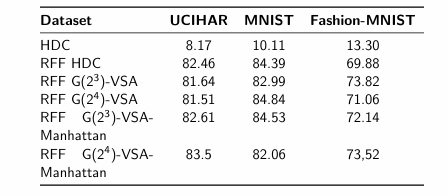